In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.mcmc_models import GP
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.test_functions import *

onp.random.seed(1234)

In [2]:
# Define test function
f, p_x, dim, lb, ub = oakley()

# Problem settings
N = 5
noise = 0.0
options = {'kernel': 'RBF',
           'criterion': 'LW-LCB', 
           'input_prior': p_x,
           'kappa': 2.0,
           'nIter': 20}
mcmc_settings = {'num_warmup': 1000,
                 'num_samples': 4000,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
gp_model = GP(options)

# Fetch domain bounds
bounds = {'lb': lb, 'ub': ub}

# Initial training data
X = lb + (ub-lb)*lhs(dim, N)
y = vmap(f)(X)
y = y + noise*y.std(0)*onp.random.normal(y.shape)

# Test data
if dim == 1:
    create_plots = True
    nn = 1000
    X_star = np.linspace(lb[0], ub[0], nn)[:,None]
    y_star = vmap(f)(X_star)
elif dim == 2:
    create_plots = True
    nn = 80
    xx = np.linspace(lb[0], ub[0], nn)
    yy = np.linspace(lb[1], ub[1], nn)
    XX, YY = np.meshgrid(xx, yy)
    X_star = np.concatenate([XX.flatten()[:,None], 
                             YY.flatten()[:,None]], axis = 1)
    y_star = vmap(f)(X_star)
else:
    create_plots = False
    nn = 20000
    X_star = lb + (ub-lb)*lhs(dim, nn)
    y_star = vmap(f)(X_star)

# True location of global minimum
idx_true = np.argmin(y_star)
true_x = X_star[idx_true,:]
true_y = y_star.min()
dom_bounds = tuple(map(tuple, np.vstack((lb, ub)).T))
result = minimize(f, true_x, jac=None, method='L-BFGS-B', bounds = dom_bounds)
true_x, true_y = result.x, result.fun

In [3]:
# Main Bayesian optimization loop
rng_key = random.PRNGKey(0)
for it in range(options['nIter']):
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, options['nIter']))
    print('-------------------------------------------------------------------')

    # Fetch normalized training data
    norm_batch, norm_const = normalize(X, y)

    # Train GP model
    print('Train GP...')
    rng_key = random.split(rng_key)[0]
    samples = gp_model.train(norm_batch,
                             rng_key,
                             mcmc_settings)
    # For now just take the average of the sample (later implement posterior inference)
    params = np.concatenate([samples['kernel_var'][:,None], 
                             samples['kernel_length'], 
                             samples['noise_var'][:,None]], axis = 1)
    opt_params = np.mean(params, axis = 0)    

    # Fit GMM
    if options['criterion'] == 'LW-LCB' or options['criterion'] == 'LW-US':
        print('Fit GMM...')
        rng_key = random.split(rng_key)[0]
        kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': bounds,
                  'rng_key': rng_key}
        gmm_vars = gp_model.fit_gmm(**kwargs, N_samples = 10000)
    else:
        gmm_vars = None

    # Compute next point via minimizing the acquisition function
    print('Computing next acquisition point...')
    kwargs = {'params': opt_params,
              'batch': norm_batch,
              'norm_const': norm_const,
              'bounds': bounds,
              'gmm_vars': gmm_vars}
    new_X = gp_model.compute_next_point(num_restarts=10, **kwargs)

    # Acquire data
    new_y = vmap(f)(new_X)
    new_y = new_y + noise*new_y.std(0)*onp.random.normal(new_y.shape)

    # Augment training data
    print('Updating data-set...')
    X = np.concatenate([X, new_X], axis = 0)
    y = np.concatenate([y, new_y], axis = 0)

    # Print current best
    idx_best = np.argmin(y)
    best_x = X[idx_best,:]
    best_y = y.min()
    print('True location: (%f,%f), True value: %f' % (true_x[0], true_x[1], true_y))
    print('Best location: (%f,%f), Best value: %f' % (best_x[0], best_x[1], best_y))
    print('New  location: (%f,%f), New  value: %f' % (new_X[0,0], new_X[0,1], new_y))

-------------------------------------------------------------------
------------------------- Iteration 1/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:08<00:00, 570.19it/s, 15 steps of size 1.28e-01. acc. prob=0.85] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      7.18     49.51      0.00      0.00      0.60    530.85      1.00
kernel_length[1]      9.56     58.45      0.00      0.00      0.86    332.63      1.00
      kernel_var      0.10      0.27      0.00      0.00      0.30   2001.53      1.00
       noise_var      0.35      1.18      0.01      0.00      0.99   2016.52      1.00

Number of divergences: 699

MCMC elapsed time: 11.42 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (0.047755,-0.041718), New  value: 6.920347
-------------------------------------------------------------------
------------------------- Iteration 2/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:08<00:00, 609.71it/s, 31 steps of size 1.03e-01. acc. prob=0.91] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      3.27     32.35      0.00      0.00      0.13    418.64      1.01
kernel_length[1]      3.42     25.91      0.00      0.00      0.71   1105.24      1.00
      kernel_var      0.10      0.26      0.00      0.00      0.33   1737.70      1.00
       noise_var      0.19      0.67      0.00      0.00      0.52   1755.08      1.00

Number of divergences: 434

MCMC elapsed time: 9.34 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-0.046612,-0.042231), New  value: 6.824547
-------------------------------------------------------------------
------------------------- Iteration 3/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:07<00:00, 630.59it/s, 31 steps of size 1.29e-01. acc. prob=0.86] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.03      0.08      0.00      0.00      0.09   2105.17      1.00
kernel_length[1]      0.17      5.64      0.00      0.00      0.23   3975.74      1.00
      kernel_var      0.11      0.28      0.00      0.00      0.36   2024.39      1.00
       noise_var      0.01      0.04      0.00      0.00      0.00   3105.23      1.00

Number of divergences: 115

MCMC elapsed time: 8.95 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-2.191255,-1.005332), New  value: -1.048085
-------------------------------------------------------------------
------------------------- Iteration 4/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:08<00:00, 584.03it/s, 31 steps of size 8.44e-02. acc. prob=0.95] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.08      2.82      0.00      0.00      0.12   3419.54      1.00
kernel_length[1]      0.07      0.16      0.00      0.00      0.24   2237.08      1.00
      kernel_var      0.06      0.18      0.00      0.00      0.17   2577.67      1.00
       noise_var      0.00      0.03      0.00      0.00      0.00   1764.58      1.00

Number of divergences: 26

MCMC elapsed time: 9.58 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-1.679425,-1.635859), New  value: -0.527882
-------------------------------------------------------------------
------------------------- Iteration 5/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:09<00:00, 534.12it/s, 31 steps of size 8.14e-02. acc. prob=0.87]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.05      0.10      0.00      0.00      0.17   1623.76      1.00
kernel_length[1]      0.10      0.21      0.00      0.00      0.39   1147.51      1.00
      kernel_var      0.06      0.16      0.00      0.00      0.16   2296.20      1.00
       noise_var      0.00      0.02      0.00      0.00      0.00   3781.46      1.00

Number of divergences: 79

MCMC elapsed time: 10.57 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (0.478866,0.971187), New  value: 9.876202
-------------------------------------------------------------------
------------------------- Iteration 6/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:09<00:00, 536.60it/s, 63 steps of size 5.64e-02. acc. prob=0.91] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.10      0.16      0.01      0.00      0.35    660.46      1.00
kernel_length[1]      0.08      0.15      0.00      0.00      0.29   1280.22      1.00
      kernel_var      0.04      0.12      0.00      0.00      0.12   2582.77      1.00
       noise_var      0.00      0.01      0.00      0.00      0.00   3253.80      1.00

Number of divergences: 10

MCMC elapsed time: 10.62 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-0.764492,-1.213832), New  value: 2.591220
-------------------------------------------------------------------
------------------------- Iteration 7/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:08<00:00, 568.72it/s, 63 steps of size 4.08e-02. acc. prob=0.93] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.09      0.13      0.01      0.00      0.30    603.77      1.00
kernel_length[1]      0.12      0.18      0.01      0.00      0.42    614.64      1.00
      kernel_var      0.04      0.11      0.00      0.00      0.11   2281.55      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   2392.02      1.00

Number of divergences: 1

MCMC elapsed time: 9.74 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-2.420127,-0.333984), New  value: 0.088592
-------------------------------------------------------------------
------------------------- Iteration 8/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:10<00:00, 487.41it/s, 31 steps of size 3.18e-02. acc. prob=0.93] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.10      0.14      0.01      0.00      0.33    485.72      1.01
kernel_length[1]      0.11      0.15      0.01      0.00      0.37    572.40      1.00
      kernel_var      0.04      0.11      0.00      0.00      0.12   1626.15      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   2068.28      1.00

Number of divergences: 0

MCMC elapsed time: 11.32 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-2.575478,-1.833798), New  value: -3.028486
-------------------------------------------------------------------
------------------------- Iteration 9/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:10<00:00, 465.13it/s, 39 steps of size 2.30e-02. acc. prob=0.97] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.15      0.15      0.10      0.00      0.37    188.78      1.00
kernel_length[1]      0.18      0.19      0.11      0.00      0.46    316.84      1.00
      kernel_var      0.04      0.12      0.00      0.00      0.12   1373.55      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   3008.35      1.00

Number of divergences: 0

MCMC elapsed time: 11.99 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-1.492880,-0.634343), New  value: 1.843154
-------------------------------------------------------------------
------------------------- Iteration 10/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:10<00:00, 463.65it/s, 7 steps of size 1.75e-02. acc. prob=0.98]  



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.22      0.17      0.24      0.00      0.44    185.45      1.00
kernel_length[1]      0.24      0.20      0.24      0.00      0.50    196.54      1.00
      kernel_var      0.04      0.11      0.00      0.00      0.10   1644.66      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   1937.84      1.00

Number of divergences: 0

MCMC elapsed time: 11.99 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.368890,-1.926324), Best value: -4.118698
New  location: (-3.368890,-1.926324), New  value: -4.118698
-------------------------------------------------------------------
------------------------- Iteration 11/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:09<00:00, 510.76it/s, 15 steps of size 3.32e-02. acc. prob=0.98] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.27      0.15      0.30      0.00      0.44    178.17      1.03
kernel_length[1]      0.37      0.17      0.40      0.08      0.64     95.08      1.02
      kernel_var      0.04      0.11      0.00      0.00      0.11   1737.78      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   1907.00      1.00

Number of divergences: 0

MCMC elapsed time: 10.89 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.368890,-1.926324), Best value: -4.118698
New  location: (-2.714667,-2.394594), New  value: -3.288627
-------------------------------------------------------------------
------------------------- Iteration 12/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:09<00:00, 519.85it/s, 87 steps of size 1.98e-02. acc. prob=0.95] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.28      0.16      0.31      0.00      0.46    182.56      1.00
kernel_length[1]      0.38      0.17      0.42      0.00      0.55    107.62      1.02
      kernel_var      0.04      0.12      0.00      0.00      0.12   1116.09      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   1553.76      1.00

Number of divergences: 0

MCMC elapsed time: 10.76 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.602282,-2.182766), Best value: -4.213577
New  location: (-3.602282,-2.182766), New  value: -4.213577
-------------------------------------------------------------------
------------------------- Iteration 13/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:16<00:00, 312.48it/s, 55 steps of size 2.13e-02. acc. prob=0.96] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.32      0.13      0.34      0.12      0.54    267.12      1.00
kernel_length[1]      0.43      0.14      0.45      0.24      0.63    174.01      1.01
      kernel_var      0.04      0.12      0.00      0.00      0.11   1401.68      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   1707.71      1.00

Number of divergences: 0

MCMC elapsed time: 17.19 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.602282,-2.182766), Best value: -4.213577
New  location: (-3.633818,-1.991973), New  value: -4.213575
-------------------------------------------------------------------
------------------------- Iteration 14/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:11<00:00, 422.46it/s, 47 steps of size 5.37e-02. acc. prob=0.97] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.26      0.14      0.29      0.00      0.41    131.13      1.00
kernel_length[1]      0.39      0.18      0.44      0.00      0.58     27.62      1.09
      kernel_var      0.04      0.11      0.00      0.00      0.10   2007.43      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   1983.89      1.00

Number of divergences: 0

MCMC elapsed time: 13.49 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.677889,-2.012196), Best value: -4.217608
New  location: (-3.677889,-2.012196), New  value: -4.217608
-------------------------------------------------------------------
------------------------- Iteration 15/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:16<00:00, 295.02it/s, 127 steps of size 2.07e-02. acc. prob=0.98] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.26      0.10      0.28      0.10      0.44    295.61      1.01
kernel_length[1]      0.45      0.12      0.47      0.26      0.63    274.45      1.01
      kernel_var      0.04      0.10      0.00      0.00      0.10   1935.51      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   2114.58      1.00

Number of divergences: 0

MCMC elapsed time: 18.30 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.656302,-2.092884), Best value: -4.223618
New  location: (-3.656302,-2.092884), New  value: -4.223618
-------------------------------------------------------------------
------------------------- Iteration 16/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:10<00:00, 497.65it/s, 31 steps of size 1.96e-01. acc. prob=0.91] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.26      0.10      0.27      0.11      0.43    130.57      1.02
kernel_length[1]      0.48      0.12      0.50      0.31      0.66    140.06      1.00
      kernel_var      0.04      0.12      0.00      0.00      0.12   1124.08      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   2469.67      1.00

Number of divergences: 32

MCMC elapsed time: 11.26 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.661838,-2.093657), Best value: -4.223678
New  location: (-3.661838,-2.093657), New  value: -4.223678
-------------------------------------------------------------------
------------------------- Iteration 17/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:11<00:00, 447.74it/s, 31 steps of size 1.02e-01. acc. prob=0.93]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.26      0.09      0.27      0.12      0.41    321.99      1.01
kernel_length[1]      0.51      0.10      0.52      0.34      0.66   1151.38      1.00
      kernel_var      0.04      0.11      0.00      0.00      0.12   2283.61      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   2872.28      1.00

Number of divergences: 2

MCMC elapsed time: 12.47 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.662220,-2.093535), Best value: -4.223680
New  location: (-3.662220,-2.093535), New  value: -4.223680
-------------------------------------------------------------------
------------------------- Iteration 18/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:14<00:00, 354.94it/s, 63 steps of size 1.00e-01. acc. prob=0.95]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.26      0.09      0.27      0.11      0.41    391.15      1.01
kernel_length[1]      0.53      0.10      0.54      0.38      0.68   1148.53      1.00
      kernel_var      0.04      0.13      0.00      0.00      0.12   1683.74      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   2008.49      1.00

Number of divergences: 1

MCMC elapsed time: 16.87 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.662220,-2.093535), Best value: -4.223680
New  location: (-3.660769,-2.093158), New  value: -4.223670
-------------------------------------------------------------------
------------------------- Iteration 19/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:19<00:00, 263.09it/s, 55 steps of size 1.99e-01. acc. prob=0.91]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.26      0.10      0.28      0.08      0.44     73.99      1.04
kernel_length[1]      0.52      0.14      0.54      0.35      0.70     51.17      1.02
      kernel_var      0.04      0.12      0.00      0.00      0.11   1198.58      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   3705.16      1.00

Number of divergences: 29

MCMC elapsed time: 20.35 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.662220,-2.093535), Best value: -4.223680
New  location: (-3.660402,-2.093072), New  value: -4.223667
-------------------------------------------------------------------
------------------------- Iteration 20/20 -------------------------
-------------------------------------------------------------------
Train GP...


sample: 100%|██████████| 5000/5000 [00:10<00:00, 456.04it/s, 15 steps of size 1.66e-01. acc. prob=0.92] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      0.26      0.09      0.28      0.12      0.41    148.92      1.01
kernel_length[1]      0.54      0.11      0.56      0.38      0.72   1163.69      1.00
      kernel_var      0.05      0.13      0.00      0.00      0.14   1815.25      1.00
       noise_var      0.00      0.00      0.00      0.00      0.00   3292.77      1.00

Number of divergences: 14

MCMC elapsed time: 12.89 seconds
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.662220,-2.093535), Best value: -4.223680
New  location: (-3.659746,-2.092328), New  value: -4.223659


In [6]:
# Test accuracy
mean, std = gp_model.predict(X_star, **kwargs)
lower = mean - 2.0*std
upper = mean + 2.0*std
# Check accuracy
error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 1.359655e-01


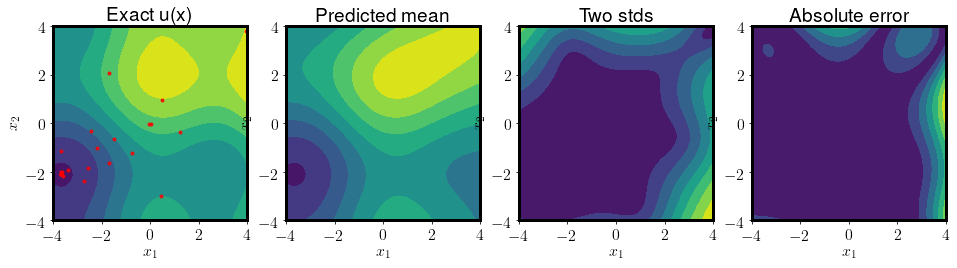

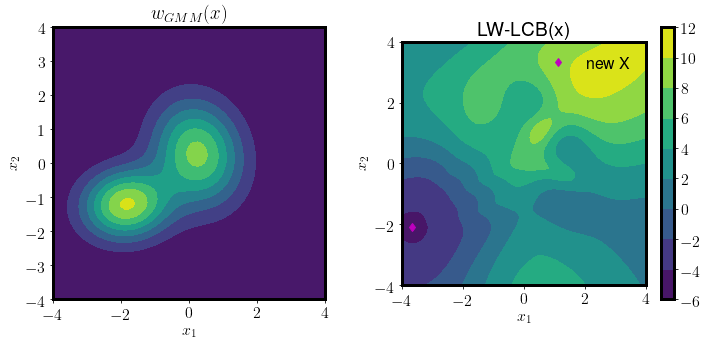

In [7]:
if create_plots:
    # Compute predictions
    if options['criterion'] == 'LW-LCB' or options['criterion'] == 'LW-US':
        w_pred = compute_w_gmm(X_star, **kwargs)
    else:
        w_pred = np.zeros(X_star.shape[0])
        
    acq_fun = lambda x: gp_model.acquisition(x, **kwargs)
    a_pred = vmap(acq_fun)(X_star)
    x_new = gp_model.compute_next_point(num_restarts=10, **kwargs)

    # Convert to NumPy
    X_star = onp.array(X_star)
    y_star = onp.array(y_star)
    mean = onp.array(mean)
    std = onp.array(std)
    w_pred = onp.array(w_pred)
    a_pred = onp.array(a_pred)
    XX = onp.array(XX)
    YY = onp.array(YY)
    Y_star = griddata(X_star, y_star, (XX, YY), method='cubic')
    Y_pred = griddata(X_star, mean, (XX, YY), method='cubic')
    Y_std  = griddata(X_star, std, (XX, YY), method='cubic')
    W_star = griddata(X_star, w_pred, (XX, YY), method='cubic')
    A_star = griddata(X_star, a_pred, (XX, YY), method='cubic')

    # Plot
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['axes.linewidth']=3
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    rc('text', usetex=True)

    plt.figure(figsize = (16,8))
    plt.subplot(1, 4, 1)
    fig = plt.contourf(XX, YY, Y_star)
    plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
    # plt.plot(true_x[0], true_x[1], 'md', ms = 8, alpha = 1.0)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Exact u(x)')
    plt.axis('square')

    plt.subplot(1, 4, 2)
    fig = plt.contourf(XX, YY, Y_pred)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Predicted mean')
    plt.axis('square')

    plt.subplot(1, 4, 3)
    fig = plt.contourf(XX, YY, 2.0*Y_std)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Two stds')
    plt.axis('square')

    plt.subplot(1, 4, 4)
    fig = plt.contourf(XX, YY, np.abs(Y_star-Y_pred))
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Absolute error')
    plt.axis('square')
#     plt.savefig('function_prediction.png', dpi = 300)

    idx_max = np.argmin(a_pred)
    plt.figure(figsize = (12,5))
    plt.subplot(1, 2, 1)
    fig = plt.contourf(XX, YY, W_star)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'$w_{GMM}(x)$')
    plt.axis('square')
    plt.subplot(1, 2, 2)
    fig = plt.contourf(XX, YY, A_star)
    plt.colorbar(fig)
    # plt.plot(x0[:,0], x0[:,1], 'ms')
    # plt.plot(X_star[idx_max,0], X_star[idx_max,1], 'md')
    plt.plot(x_new[:,0], x_new[:,1], 'md', label = 'new X')
    plt.legend(frameon = False)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'%s(x)' % (options['criterion']))
    plt.axis('square')
#     plt.savefig('acquisition.png', dpi = 300)